<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1703_feature_selection_08_filter_wrapper_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Load & Preprocess

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, SelectFromModel
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_classification_report_metrics, plot_selected_features, ThresholdClassifier

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])


# Apply preprocessing to the training data
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)))

# Apply SMOTE after preprocessing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=3000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

## Filter
The choice of a threshold value in `VarianceThreshold` is crucial because it determines which features are considered low-variance and should be removed. Here's why a low value like `0.01` might be used:

### 1. **Feature Scale Consideration**:
   - **Standardization**: If your features are standardized (e.g., using `StandardScaler`), they typically have a mean of 0 and a standard deviation of 1. This means that most of the variance in each feature will be around 1. Setting a threshold of `0.01` in this context would remove features that are nearly constant but allow most standardized features to remain.

### 2. **High-Dimensional Data**:
   - In high-dimensional datasets with a large number of features, there might be some features that have very low variance across samples, potentially adding noise to the model. A low threshold helps in identifying and removing such features.

### 3. **Avoiding Over-Filtering**:
   - If you set the threshold too high, you might inadvertently remove features that are important but have lower variance. A threshold like `0.01` is conservative, ensuring that only features with extremely low variance (i.e., close to being constant) are removed.

### 4. **Domain-Specific Considerations**:
   - In some domains, even features with low variance might carry significant information. By setting a low threshold, you're more likely to retain features that could be relevant to the model.

### Example:
If you have a feature that records whether a customer has defaulted on a payment in the past (binary: 0 or 1), and 99% of the values are 0 (no default), the variance of this feature will be very low. However, it might still be an important feature for predicting future defaults. Setting the threshold too high might remove such a feature.

### Summary:
A threshold of `0.01` is chosen to strike a balance between removing features that are almost constant (which likely won't contribute to the model) and retaining features that, while having low variance, might still hold predictive power. If you want to be more aggressive in filtering out low-variance features, you could increase the threshold, but this risks losing potentially valuable features.

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.23      0.37      4673
           1       0.25      0.88      0.38      1327

    accuracy                           0.38      6000
   macro avg       0.56      0.56      0.38      6000
weighted avg       0.73      0.38      0.37      6000



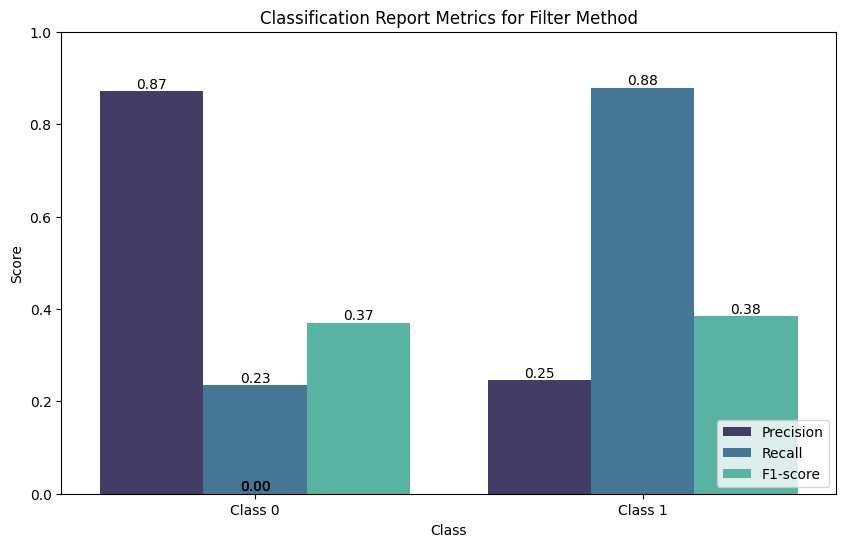

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif

# Apply Variance Threshold
var_thresh = VarianceThreshold(threshold=0.01)
X_train_filtered = var_thresh.fit_transform(X_train_res)

# Apply Univariate Feature Selection (e.g., Mutual Information)
select_kbest = SelectKBest(mutual_info_classif, k=20)  # Adjust k based on your needs
X_train_filtered = select_kbest.fit_transform(X_train_filtered, y_train_res)

# Preprocess the test data (no resampling here)
X_test_preprocessed = preprocessor.transform(X_test)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)))
X_test_filtered = var_thresh.transform(X_test_preprocessed)
X_test_filtered = select_kbest.transform(X_test_filtered)

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=3000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Train the model and evaluate
classifier.fit(X_train_filtered, y_train_res)
y_pred = classifier.predict(X_test_filtered)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Store the classification report
classification_report_results = classification_report(y_test, y_pred, output_dict=True)

# Plot the classification report metrics
plot_classification_report_metrics(classification_report_results, 'Filter Method')

## Wrapper Grid Search

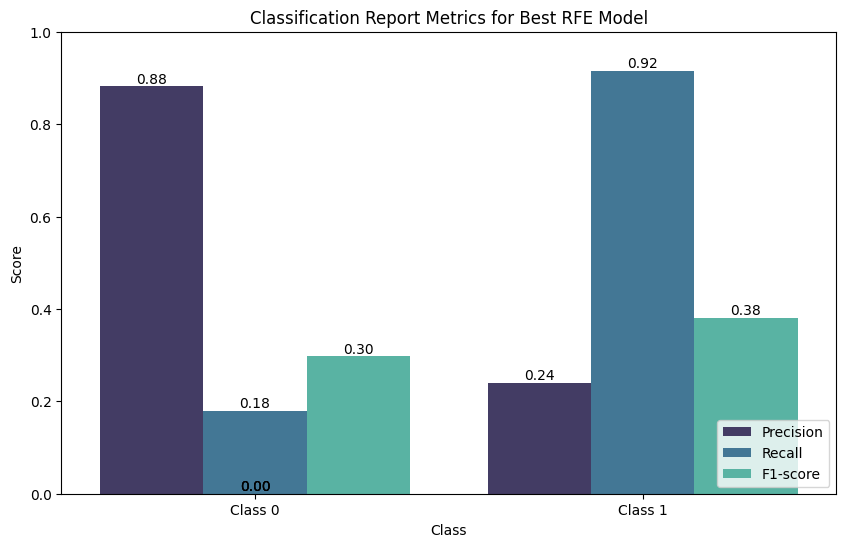

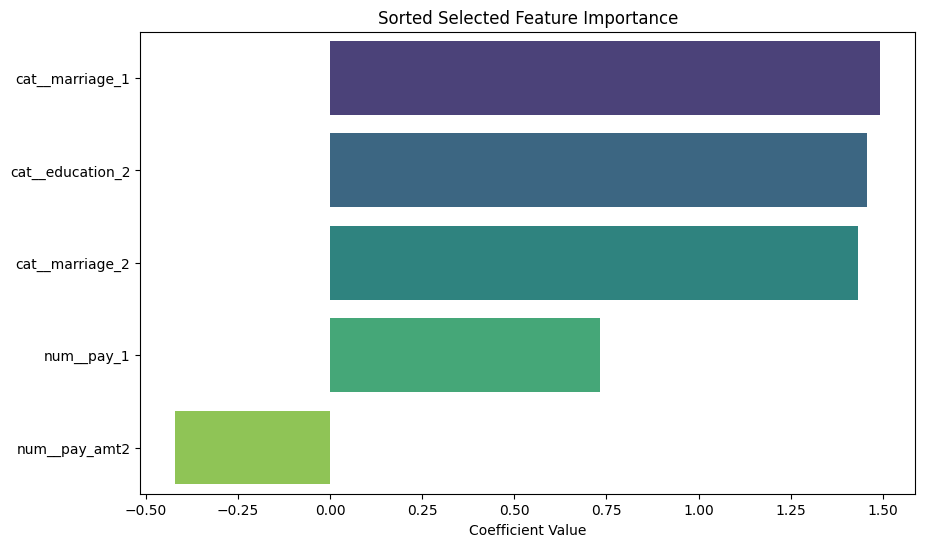

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.18      0.30      4673
           1       0.24      0.92      0.38      1327

    accuracy                           0.34      6000
   macro avg       0.56      0.55      0.34      6000
weighted avg       0.74      0.34      0.32      6000



In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=3000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Set up the RFE with the base classifier
rfe = RFE(estimator=base_classifier)

# Create a pipeline including preprocessing, SMOTE, variance thresholding, feature selection, and classification
pipeline_rfe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step (imputer, scaler, encoder)
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE inside the pipeline
    ('var_thresh', var_thresh),  # Variance threshold filtering
    ('select_kbest', select_kbest),  # Univariate feature selection
    ('rfe', rfe),  # Recursive feature elimination
    ('classifier', classifier)  # Custom threshold classifier
])

# Set up the parameter grid to tune the number of features selected by RFE
param_grid = {
    'rfe__n_features_to_select': np.linspace(5, X_train_filtered.shape[1], 5, dtype=int).tolist()
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline_rfe, param_grid=param_grid, cv=cv, scoring='recall', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)  # Use X_train and y_train directly

# Get the best model (RFE) from the grid search
best_rfe = grid_search.best_estimator_.named_steps['rfe']

# Determine the number of selected features
selected_feature_names = np.array(preprocessor.get_feature_names_out())[var_thresh.get_support()][select_kbest.get_support()][best_rfe.support_]

# Sort the selected features by their importance (coefficient value)
sorted_indices = np.argsort(np.abs(best_rfe.estimator_.coef_[0]))[::-1]
sorted_feature_names = selected_feature_names[sorted_indices]
sorted_feature_importances = best_rfe.estimator_.coef_[0][sorted_indices]

# Evaluate on the test set (no need for manual transformation)
y_pred = grid_search.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Call the plot function
plot_classification_report_metrics(report, 'Best RFE Model')

# Plot the sorted features
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names, palette='viridis')
plt.xlabel('Coefficient Value')
plt.title('Sorted Selected Feature Importance')
plt.show()

# Print the classification report
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))



#Ensemble

Sorted combined ensemble feature importance saved to 'selected_features_filter_wrapper_ensemble_sorted.json'


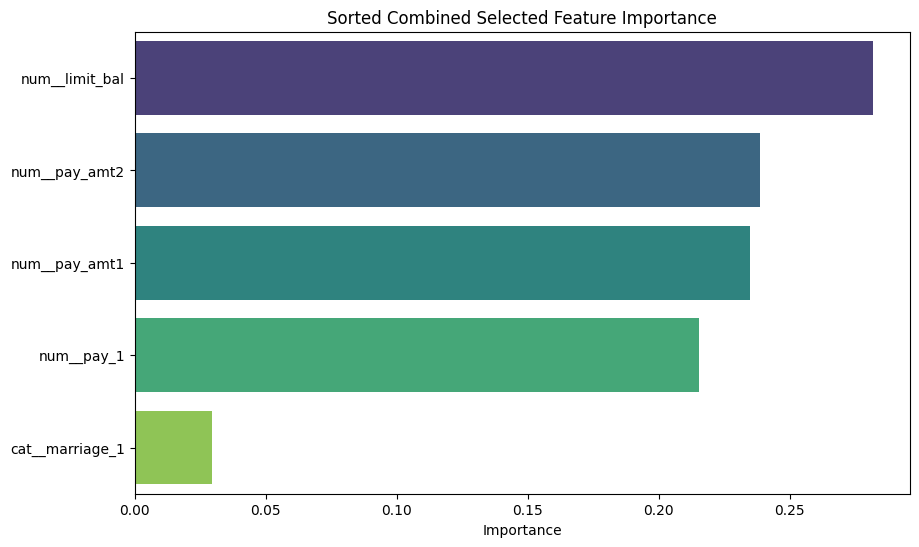

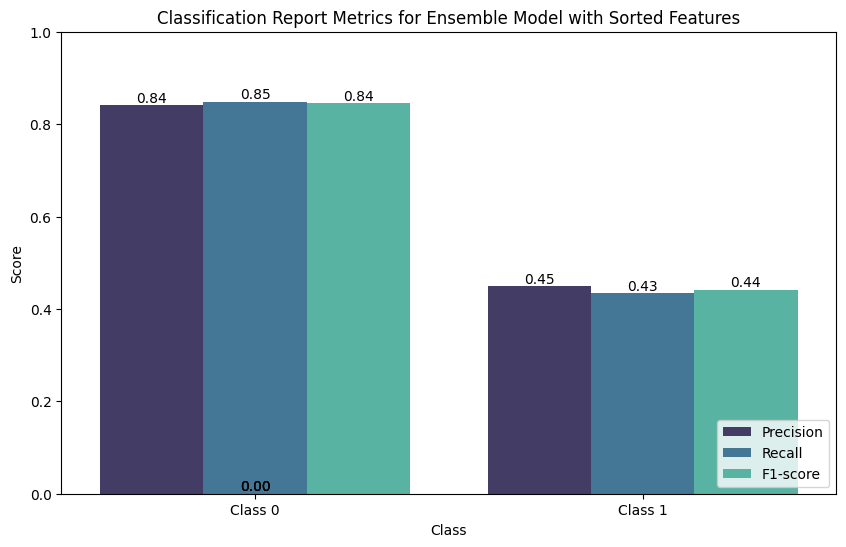

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      4673
           1       0.45      0.43      0.44      1327

    accuracy                           0.76      6000
   macro avg       0.64      0.64      0.64      6000
weighted avg       0.75      0.76      0.76      6000



In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=3000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Set up the RFE with the base classifier
rfe = RFE(estimator=base_classifier)

# Create the ensemble model
ensemble_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a pipeline including preprocessing, SMOTE, variance thresholding, feature selection, and ensemble classification
pipeline_ensemble = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step (imputer, scaler, encoder)
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE inside the pipeline
    ('var_thresh', var_thresh),  # Variance threshold filtering
    ('select_kbest', select_kbest),  # Univariate feature selection
    ('rfe', rfe),  # Recursive feature elimination
    ('ensemble', ensemble_classifier)  # Ensemble classifier (e.g., Random Forest)
])

# Set up the parameter grid to tune the number of features selected by RFE
param_grid = {
    'rfe__n_features_to_select': np.linspace(5, X_train_filtered.shape[1], 5, dtype=int).tolist()
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline_ensemble, param_grid=param_grid, cv=cv, scoring='recall', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)  # Use X_train and y_train directly

# Get the best model from the grid search
best_pipeline = grid_search.best_estimator_

# Access the RFE step from the best pipeline
best_rfe = best_pipeline.named_steps['rfe']
selected_features_rfe = best_rfe.support_

# Get the feature names after preprocessing and feature selection
selected_feature_names = np.array(preprocessor.get_feature_names_out())[var_thresh.get_support()][select_kbest.get_support()][selected_features_rfe]

# Get feature importances from the ensemble model
ensemble_model = best_pipeline.named_steps['ensemble']
feature_importances = ensemble_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = selected_feature_names[sorted_indices]
sorted_feature_importances = feature_importances[sorted_indices]

# Save the sorted combined selected features to a JSON file
combined_feature_importance_dict = {
    'Feature': sorted_feature_names.tolist(),
    'Importance': sorted_feature_importances.tolist(),
    'Rank': list(map(int, np.arange(1, len(sorted_feature_names) + 1)))
}

with open('selected_features_filter_wrapper_ensemble_sorted.json', 'w') as f:
    json.dump(combined_feature_importance_dict, f, indent=4)
print("Sorted combined ensemble feature importance saved to 'selected_features_filter_wrapper_ensemble_sorted.json'")

# Plot the sorted combined selected features importance
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names, palette='viridis')
plt.xlabel('Importance')
plt.title('Sorted Combined Selected Feature Importance')
plt.show()

# Plot the classification report metrics
y_pred = grid_search.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
plot_classification_report_metrics(report, 'Ensemble Model with Sorted Features')

# Print the classification report
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))


### Best Pipeline

In [ ]:
# Get the best pipeline from GridSearchCV
best_pipeline = grid_search.best_estimator_

# Print the best pipeline
print("Best Pipeline Steps:")
print(best_pipeline)

# You can also break down and inspect each step:
print("\nPipeline Steps Breakdown:")
for step_name, step in best_pipeline.named_steps.items():
    print(f"Step: {step_name}")
    print(step)
    print("-" * 50)


Best Pipeline Steps:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['limit_bal', 'age', 'pay_1',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
           

Classification report saved to 'classification_reports_filter_wrapper_ensemble.json'
Sorted combined ensemble feature importance saved to 'selected_features_filter_wrapper_ensemble_sorted.json'


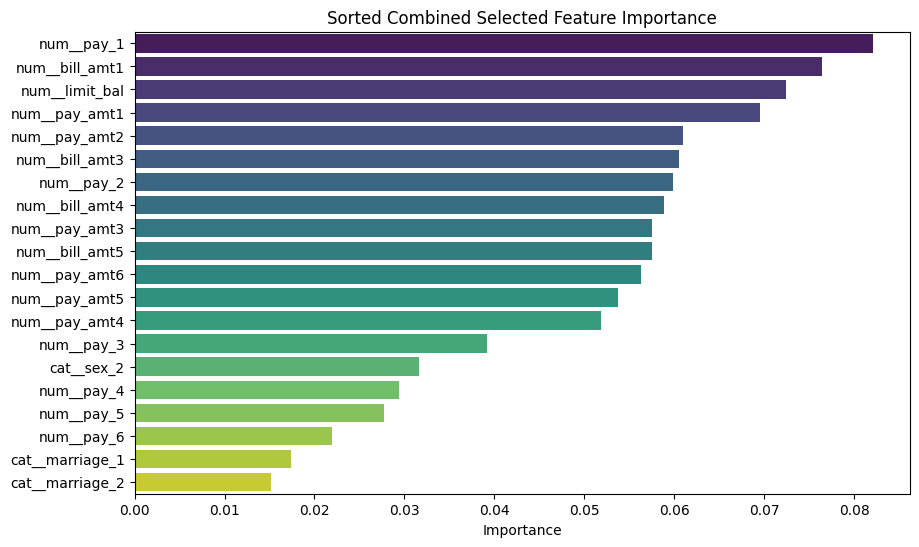

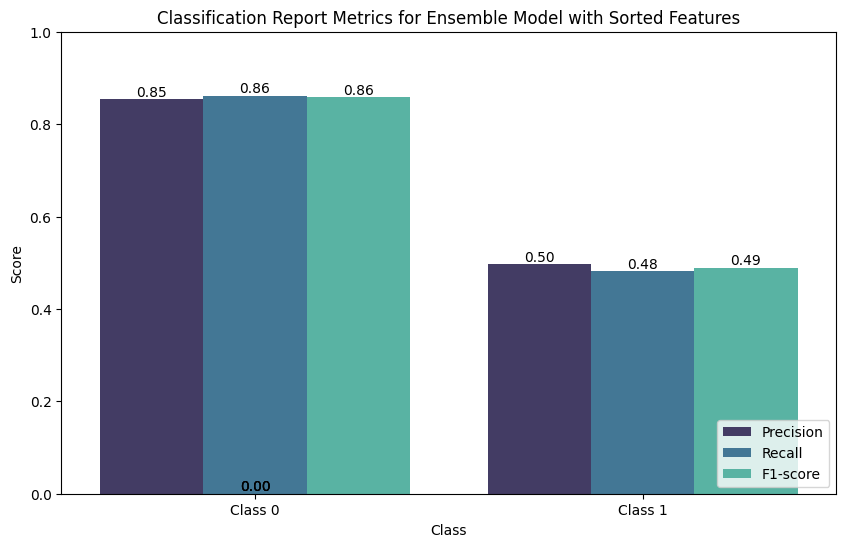

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      4673
           1       0.50      0.48      0.49      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.67      0.67      6000
weighted avg       0.78      0.78      0.78      6000



In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Use the optimal features from RFE
# X_train_wrapper_selected = best_rfe.transform(X_train_filtered)

# # Train the Ensemble Model (e.g., RandomForest) using the selected features
# ensemble_model = RandomForestClassifier(n_estimators=100, random_state=42)
# ensemble_model.fit(X_train_wrapper_selected, y_train_res)

# # Get feature importances from the ensemble model
# feature_importances = ensemble_model.feature_importances_
# sorted_indices = np.argsort(feature_importances)[::-1]
# sorted_feature_names = selected_feature_names[sorted_indices]
# sorted_feature_importances = feature_importances[sorted_indices]

# # Combine the selected features (Top features from ensemble + RFE features)
# combined_selected_features = list(set(selected_feature_names).union(set(sorted_feature_names[:10])))  # Example: Top 10 ensemble features

# # Ensure that all features in the combined_selected_features list are strings
# combined_selected_features = [str(feature) for feature in combined_selected_features]

# # Find the indices for these combined features
# combined_selected_indices = [np.where(selected_feature_names == feature)[0][0] for feature in combined_selected_features]
# X_train_combined_selected = X_train_wrapper_selected[:, combined_selected_indices]
# X_test_filtered = select_kbest.transform(var_thresh.transform(preprocessor.transform(X_test)))
# X_test_combined_selected = X_test_filtered[:, combined_selected_indices]

# # Train and evaluate the ensemble model on the selected features
# ensemble_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# ensemble_classifier.fit(X_train_combined_selected, y_train_res)
# y_pred_ensemble = ensemble_classifier.predict(X_test_combined_selected)

# # Save the classification report to a JSON file
# classification_report_ensemble = classification_report(y_test, y_pred_ensemble, output_dict=True)
# results = {'Ensemble': classification_report_ensemble}

# with open('classification_reports_filter_wrapper_ensemble.json', 'w') as f:
#     json.dump(results, f, indent=4)
# print("Classification report saved to 'classification_reports_filter_wrapper_ensemble.json'")

# # Sort the combined selected features by their importance
# combined_feature_importance_dict = {
#     'Feature': combined_selected_features,
#     'Importance': [sorted_feature_importances[sorted_feature_names.tolist().index(feature)]
#                    if feature in sorted_feature_names else 0
#                    for feature in combined_selected_features],
#     'Rank': list(map(int, np.arange(1, len(combined_selected_features) + 1)))
# }

# # Sort the combined selected features by their importance again after combining
# sorted_combined_indices = np.argsort(combined_feature_importance_dict['Importance'])[::-1]
# sorted_combined_features = [combined_selected_features[i] for i in sorted_combined_indices]
# sorted_combined_importances = [combined_feature_importance_dict['Importance'][i] for i in sorted_combined_indices]

# # Update the dictionary with sorted features and importances
# combined_feature_importance_dict = {
#     'Feature': sorted_combined_features,
#     'Importance': sorted_combined_importances,
#     'Rank': list(map(int, np.arange(1, len(sorted_combined_features) + 1)))
# }

# # Save the sorted combined selected features to a JSON file
# with open('selected_features_filter_wrapper_ensemble_sorted.json', 'w') as f:
#     json.dump(combined_feature_importance_dict, f, indent=4)
# print("Sorted combined ensemble feature importance saved to 'selected_features_filter_wrapper_ensemble_sorted.json'")

# # Plot the sorted combined selected features importance
# plt.figure(figsize=(10, 6))
# sns.barplot(x=sorted_combined_importances, y=sorted_combined_features, palette='viridis')
# plt.xlabel('Importance')
# plt.title('Sorted Combined Selected Feature Importance')
# plt.show()

# # Plot the classification report metrics
# plot_classification_report_metrics(classification_report_ensemble, 'Ensemble Model with Sorted Features')

# # Print the classification report
# print("Test Set Classification Report:")
# print(classification_report(y_test, y_pred_ensemble))


#### Loan Data Utils

In [ ]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Custom Classifier   --------#

# Define a custom classifier to handle class-specific threshold
class ThresholdClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, threshold=0.3):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)


#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


# #--------   Plot Classification Report  --------#

# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

def plot_classification_report_thresholds(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

# #--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
